### Battery life model library
Example notebook demonstrating how to use the battery life models in Python.

First examples use the Kokam NMC111|Gr 75Ah battery life model. The battery modeled here is a high-power cell with long cycle life. Because nominal cell resistance is low, the relative change of resistance at end-of-life is quite high compared to other cell designs (~300% increase in cell resistance at 80% capacity if not more). Fade rates can be changed in the code to accomodate other cell models. Documentation is provided in the life model class. See https://ieeexplore.ieee.org/abstract/document/7963578 for the aging test details and results used to parameterize this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery

To run, the life model needs timeseries data: the time in seconds since beginning-of-life of the battery, the state-of-charge of the battery (0 to 1), and the ambient temperature (or battery temperature, if you have a thermal model).

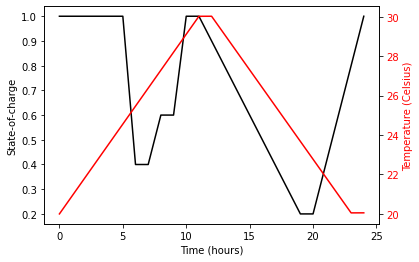

In [2]:
years = 10
hours = years * 365 * 24
t_hours = np.arange(hours + 1)
soc = np.tile(
    np.array(
        [1, 1, 1, 1, 1, 1,
        0.4, 0.4, 0.6, 0.6, 1, 1,
        0.9, 0.8, 0.7, 0.6, 0.5, 0.4,
        0.3, 0.2, 0.2, 0.4, 0.6, 0.8]
        ),
    int(len(t_hours/24))
)
soc = np.append(soc, 1)

TdegC = (
    np.tile(np.concatenate([np.linspace(25, 35, 12), np.linspace(35, 25, 12)]),
    int(len(t_hours)/24))
    + np.tile(np.concatenate([np.linspace(-5, 5, 24*182), np.linspace(5, -5, 24*183)]),
    int(len(t_hours)/(24*365)))
)
TdegC = np.append(TdegC, 20)

t_secs = t_hours * 3600

fig, ax1 = plt.subplots()
ax1.plot(t_hours[:25], soc[:25], '-k')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('State-of-charge')

ax2 = ax1.twinx()
ax2.plot(t_hours[:25], TdegC[:25], '-r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (Celsius)', color='r')
plt.show()

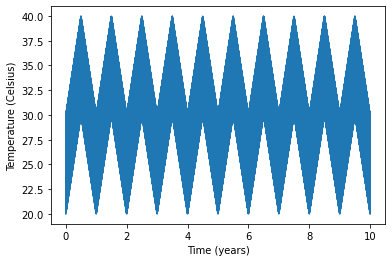

In [3]:
plt.plot(t_hours/(24*365), TdegC)
plt.xlabel('Time (years)')
plt.ylabel('Temperature (Celsius)')
plt.show()

Instantiate the battery model.

In [4]:
cell = Nmc111_Gr_Kokam75Ah_Battery()

All battery models have five properties. The first is `_cap`, which is the nominal discharge capacity of the cell in Amp hours.

In [5]:
cell._cap

75

The next four track battery lifetime values, and store the history of the battery as lifetime is simulated  at each timestep/iteration:
- `states`: internal states of the battery model
    - Ex., time-dependent capacity loss
- `outputs`: battery properties calculated from states
    - Ex., relative discharge capacity
- `stressors`: values of stressors used by the model
    - Ex., temperature, depth-of-discharge, charge-throughput
    - Note that degradation rates are calculate from stressor timeseries, and then normalized for the timestep; for example, an Arrhenius expression would be evaluated from the temperature timeseries for the entire timestep, and then normalized by taking the time-based average - this gives a different value than if the Arrhenius expression was evaluated on the averager temperature. Other normalizations can include using the minimum or maximum value over the timestep, or using the root-mean-square.
- `rates`: values of degradation rates
    - Ex., time-dependent degradation rate due to temperature and state-of-charge

Battery models may have other properties, such as the open-circuit voltage as a function of state-of-charge, nominal DC resistance values, or first-life/second-life capacity definitions.

This specific battery model is relatively complex, and has many states and outputs that describe the degradation state of the battery. Properties `states`, `outputs`, `stressors`, and `rates` are all stored in dicts:

In [6]:
cell.outputs

{'q': array([1]),
 'q_LLI': array([1]),
 'q_LLI_t': array([1]),
 'q_LLI_EFC': array([1]),
 'q_LAM': array([1.01]),
 'r': array([1]),
 'r_LLI': array([1]),
 'r_LLI_t': array([1]),
 'r_LLI_EFC': array([1]),
 'r_LAM': array([1])}

Output descriptions are in the class definition, replicated here:
- q: relative capacity
- q_LLI: relative lithium inventory
- q_LLI_t: relative lithium inventory, time dependent loss
- q_LLI_EFC: relative lithium inventory, charge-throughput dependent loss
- q_LAM: relative active material, charge-throughput dependent loss
- r: relative resistance
- r_LLI: relative SEI resistance
- r_LLI_t: relative SEI resistance, time dependent growth
- r_LLI_EFC: relative SEI resistance, charge-throughput dependent growth
- r_LAM: relative electrode resistance, q_LAM dependent growth

Accesing one output/state/rate/stressor is simple:

In [7]:
cell.outputs['q']

array([1])

The battery model should be run in timesteps relavent to battery degradation, such as once per day. Larger or smaller timesteps could be used if desired, but timesteps should avoid splitting up cycles, or at least be long enough that miscounting cycles due to splitting them up does not introduce much error.

Each battery model tracks the history of it's inputs (`stressors`), calculated degradation rates (`rates`), internal states (`states`), and outputs (`outputs`) each time `update_battery_state` is called. Debugging models is easier because the values of all inputs, internal calculations, and outputs are tracked.

In [8]:
t_days = np.arange(years*365)
for day in t_days:
    hour_start = day*24
    hour_end = (day+1)*24 + 1
    # Update battery state
    cell.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])

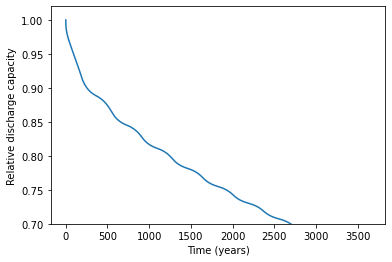

In [10]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'])
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

The cell resistance and capacity trajectories are wiggily because the temperature of the battery is varying throughout each year, varying the degradation rate. Dispatch is the same each day, so that is constant.

The model keeps track of how much charge-throughput has occured throughout life, as well, based on the input state-of-charge timeseries. Conversion from charge-throughput, in Amp-hours, to changes of cell state-of-charge, which is dependent on battery performance (health, temperature and SOC dependent resistances), is assumed to happen externally to the model. This simple simulation is essentially assuming that the current magnitude is continuously being adjusted based on the the state-of-health of the battery.

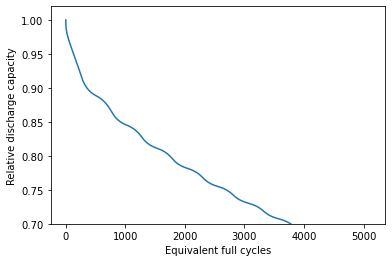

In [15]:
plt.plot(cell.stressors['efc'], cell.outputs['q'])
plt.xlabel('Equivalent full cycles')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

This dispatch has a little more than 1 EFC per day.

We can plot the separate contributions to capacity or resistance fade, as well.

(0.7, 1.02)

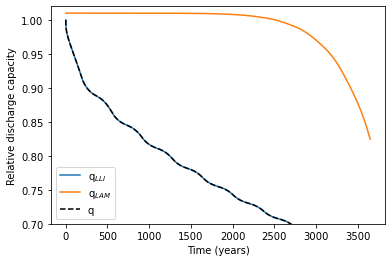

In [11]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend([r'q$_{LLI}$', r'q$_{LAM}$', 'q'])
plt.ylim((0.7, 1.02))

From the result, the cell will experience sudden failure very shortly; considering this is near 70% remaining capacity, this is physically reasonable.

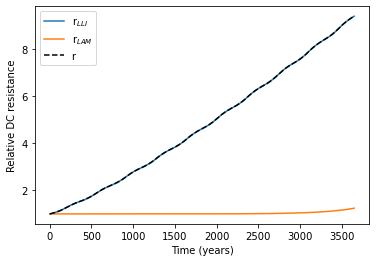

In [14]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend([r'r$_{LLI}$', r'r$_{LAM}$', 'r'])
plt.show()

Repeat with other battery life models.

c:\Users\pgasper\Documents\GitHub\BLAST-Py\functions\state_functions.py:16: RuntimeWarning: invalid value encountered in double_scalars
  dydx = k*p*((y0/k)**((p-1)/p))


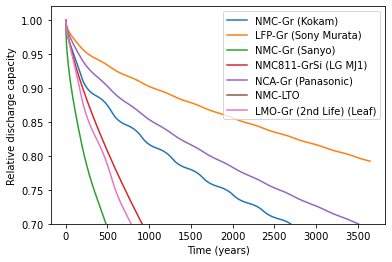

In [16]:
from lfp_gr_SonyMurata3Ah_2018 import Lfp_Gr_SonyMurata3Ah_Battery
from nmc111_gr_Sanyo2Ah_2014 import Nmc111_Gr_Sanyo2Ah_Battery
from nmc811_grSi_LGMJ1_4Ah_2020 import Nmc811_GrSi_LGMJ1_4Ah_Battery
from nca_gr_Panasonic3Ah_2018 import Nca_Gr_Panasonic3Ah_Battery
from nmc_lto_10Ah_2020 import Nmc_Lto_10Ah_Battery
from lmo_gr_NissanLeaf66Ah_2ndLife_2020 import Lmo_Gr_NissanLeaf66Ah_2ndLife_Battery

cell_nmc_kokam = Nmc111_Gr_Kokam75Ah_Battery()
cell_lfp = Lfp_Gr_SonyMurata3Ah_Battery()
cell_nmc_sanyo = Nmc111_Gr_Sanyo2Ah_Battery()
cell_nmc811_grSi = Nmc811_GrSi_LGMJ1_4Ah_Battery()
cell_nca = Nca_Gr_Panasonic3Ah_Battery()
cell_nmc_lto = Nmc_Lto_10Ah_Battery()
cell_lmo = Lmo_Gr_NissanLeaf66Ah_2ndLife_Battery()

for day in t_days:
    hour_start = day*24
    hour_end = (day+1)*24 + 1
    # NMC Kokam
    cell_nmc_kokam.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # LFP
    cell_lfp.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # NMC Sanyo
    cell_nmc_sanyo.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # LG MJ1 NMC811 GrSi
    cell_nmc811_grSi.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # NCA Panasonic
    cell_nca.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # NMC LTO
    cell_nmc_lto.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    # LMO Nissan Leaf
    cell_lmo.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])

plt.plot(cell_nmc_kokam.stressors['t_days']/365, cell_nmc_kokam.outputs['q'])
plt.plot(cell_lfp.stressors['t_days']/365, cell_lfp.outputs['q'])
plt.plot(cell_nmc_sanyo.stressors['t_days']/365, cell_nmc_sanyo.outputs['q'])
plt.plot(cell_nmc811_grSi.stressors['t_days']/365, cell_nmc811_grSi.outputs['q'])
plt.plot(cell_nca.stressors['t_days']/365, cell_nca.outputs['q'])
plt.plot(cell_nmc_lto.stressors['t_days']/365, cell_nmc_lto.outputs['q'])
plt.plot(cell_lmo.stressors['t_days']/365, cell_lmo.outputs['q'])
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend(['NMC-Gr (Kokam)','LFP-Gr (Sony Murata)', 'NMC-Gr (Sanyo)', 'NMC811-GrSi (LG MJ1)', 'NCA-Gr (Panasonic)', 'NMC-LTO', 'LMO-Gr (2nd Life) (Leaf)'])
plt.ylim((0.7, 1.02))
plt.show()

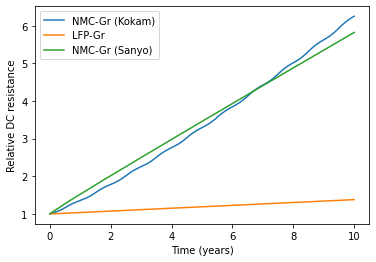

In [14]:
plt.plot(t_days/365, cell_metrics[5,:])
plt.plot(t_days/365, cell_lfp_metrics[4,:])
plt.plot(t_days/365, cell_nmc_metrics[3,:])
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend(['NMC-Gr (Kokam)','LFP-Gr', 'NMC-Gr (Sanyo)'])

Note that the LFP-Gr cell has much lower resistance growth, relative to the capacity loss. This is more like the magnitude of resistance growth seen by most cells. The NMC-Gr cell from Kokam has much higher resistance growth relative to its capacity loss, likely due to a high power cell design and details of the testing protocol and curve fitting to calculate the DC resistance value from pulse data. NMC-Gr cell from Sanyo has very poor predicted lifetime, with high resistance growth and rapid capacity loss. This reflects the experimentally measured aging data (Sanyo: ~500 EFC cycle life at 80% DOD, Kokam: > 4000 EFC cycle life at 80% DOD).

Try the NMC|Gr Kokam life model on another simple profile with low lithium loss rate but rapid active material loss driven by low temperature cycling.

Text(0, 0.5, 'Temperature (Celsius)')

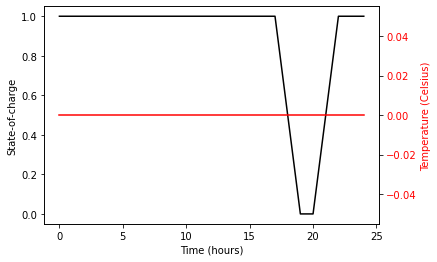

In [15]:
years = 10
hours = years * 365 * 24
t_hours = np.arange(hours)
soc = np.tile(
    np.array(
        [1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1,
         0.5, 0, 0, 0.5, 1, 1]
        ),
    int(len(t_hours/24))
)
TdegC = 0 * np.ones(t_hours.shape)
t_secs = t_hours * 3600

fig, ax1 = plt.subplots()
ax1.plot(t_hours[:25], soc[:25], '-k')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('State-of-charge')

ax2 = ax1.twinx()
ax2.plot(t_hours[:25], TdegC[:25], '-r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (Celsius)', color='r')

In [16]:
cell_2 = Nmc111_Gr_Kokam75Ah_Battery()

t_days = np.arange(years*365)
cell_2_metrics = np.zeros((len(cell_2.outputs), len(t_days)))

for day in t_days:
    hour_start = day*24
    hour_end = (day+1)*24
    cell_2.update_battery_state(t_secs=t_secs[hour_start:hour_end], soc=soc[hour_start:hour_end], T_celsius=TdegC[hour_start:hour_end])
    cell_2_metrics[:,day] = np.array(list(cell_2.outputs.values()))

(0.9, 5.0)

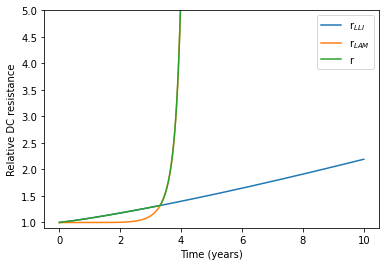

In [17]:
plt.plot(t_days/365, cell_2_metrics[6,:])
plt.plot(t_days/365, cell_2_metrics[9,:])
plt.plot(t_days/365, cell_2_metrics[5,:])
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend([r'r$_{LLI}$', r'r$_{LAM}$', 'r'])
plt.ylim((0.9, 5))

(0.7, 1.02)

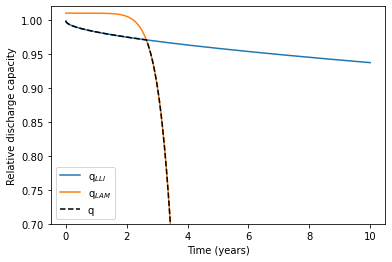

In [18]:
plt.plot(t_days/365, cell_2_metrics[1,:])
plt.plot(t_days/365, cell_2_metrics[4,:])
plt.plot(t_days/365, cell_2_metrics[0,:], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend([r'q$_{LLI}$', r'q$_{LAM}$', 'q'])
plt.ylim((0.7, 1.02))